In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.spatial.distance import squareform, pdist
import timeit
import random
from math import exp,sqrt,pi,e
from scipy.optimize import curve_fit

In [128]:
def Initialization() : #gas
    global N 
    global L
    N = 100
    L = 30
    v_max = 2
    dots = []
    for i in range(1 , 11) :
        for j in range(1 , 11) :
            dots.append([(L/20)*j, (L/10)*i, np.random.uniform(-v_max,v_max), np.random.uniform(-v_max,v_max)])
        
    dots = np.array(dots)     
    v_cmx = np.mean(dots[:,2]) 
    v_cmy = np.mean(dots[:,3]) 
    dots[:,2] = dots[:,2] - v_cmx
    dots[:,3] = dots[:,3] - v_cmy
    return(dots)

In [129]:
global dots
dots = Initialization() 

In [149]:
def Initialization() : #liquid
    global N 
    global L
    N = 100
    L = 30
    v_max = 0.108
    dots = []
    for i in range(1 , 11) :
        for j in range(1 , 11) :
            dots.append([(L/20)*j, (L/10)*i, np.random.uniform(-v_max,v_max), np.random.uniform(-v_max,v_max)])
        
    dots = np.array(dots)     
    v_cmx = np.mean(dots[:,2]) 
    v_cmy = np.mean(dots[:,3]) 
    dots[:,2] = dots[:,2] - v_cmx
    dots[:,3] = dots[:,3] - v_cmy
    return(dots)

In [150]:
global dots
dots = Initialization() 

In [157]:
def Initialization() : #solid
    global N 
    global L
    N = 100
    L = 30
    #v_max = 0.01
    #v_max = 0.005
    #v_max = 0.0005
    #v_max = 0.00001
    v_max = 0.00000001
    dots = []
    for i in range(1 , 11) :
        for j in range(1 , 11) :
            dots.append([(L/20)*j, (L/10)*i, np.random.uniform(-v_max,v_max), np.random.uniform(-v_max,v_max)])
        
    dots = np.array(dots)     
    v_cmx = np.mean(dots[:,2]) 
    v_cmy = np.mean(dots[:,3]) 
    dots[:,2] = dots[:,2] - v_cmx
    dots[:,3] = dots[:,3] - v_cmy
    return(dots)

In [158]:
global dots
dots = Initialization() 

In [26]:
def Compute_Forces() :
    
    r_cutoff = 2.5
    a_x = np.zeros(N)
    a_y = np.zeros(N)
    ene_pot = np.zeros(N) #potential energy
    pot_en = 0 #potential energy
    virial = 0
    
    for i in range(N-1):
        for j in range(i+1,N):
            x_ij = dots[:,0][i] - dots[:,0][j]
            y_ij = dots[:,1][i] - dots[:,1][j] 
            
            if abs(x_ij) > r_cutoff and x_ij > L/2:
                x_ij -= L     
            if abs(x_ij) > r_cutoff and x_ij < -L/2:
                x_ij += L  
                      
            if abs(y_ij) > r_cutoff and y_ij > L/2:
                y_ij -= L
            if abs(y_ij) > r_cutoff and y_ij < -L/2:
                y_ij += L
                
            r = np.sqrt(x_ij**2 + y_ij**2)
            r_2 = r*r
            r_6 = r_2*r_2*r_2
            r_12 = r_6*r_6
            
            rc_2 = r_cutoff*r_cutoff
            rc_6 = rc_2*rc_2*rc_2
            rc_12 = rc_6*rc_6
            
            if r < r_cutoff:
              
                dU = -4*((6/r_6 - 12/r_12))/r_2
                virial +=  dU*r 
                
                a_x[i] +=  dU*x_ij
                a_x[j] -=  dU*x_ij
                
                a_y[i] +=  dU*y_ij
                a_y[j] -=  dU*y_ij
                
                U = ((4 /r_12 - 4 /r_6) - (4 /rc_12 - 4 /rc_6)) #Lenard jones potential
                
                ene_pot[i] += U/2 
                ene_pot[j] += U/2 
                
    return(a_x,a_y,np.sum(ene_pot),virial)

In [107]:
def Check_CM_velocity():
    vx_cm = np.mean(dots[:,2])
    vy_cm = np.mean(dots[:,3])
    dots[:,2] = dots[:,2] - vx_cm
    dots[:,3] = dots[:,3]- vy_cm

In [151]:
#initial kinetic energy 
kinetic_init = 0
kinetic_init = ((dots[:,2])**2 + (dots[:,3])**2)/2  

In [109]:
def correlation_function(x,n):
    sigma2 = np.var(x[:-n:]) + ((np.mean(x[:-n:]))*np.mean(x[:-n:]))
    N = len(x)
    correlation = np.zeros((n))
    correlation[0] =1
    for j in range(1,n):
        correlation[j] = (np.sum(x[:-j] * x[j:])/N)/sigma2
    return correlation;

In [159]:
start=timeit.default_timer()

Time = 5000
h = 10**(-3) 
KB = 1/120
density = N/(L*L)
N_L = [] 
N_L.append(N)
Kinetic_energy = np.zeros(Time)
Kinetic_energy[0] = np.sum(kinetic_init)
kinetic = 0
Potential_energy = np.zeros(Time)
Potential_energy[0] = 0
Energy = np.zeros(Time) #total energy
Energy[0] = (np.sum(kinetic_init) + 0)
Temperature = np.zeros(Time)
Temperature[0] = np.sum(kinetic_init) /(N*KB)
Virial = np.zeros(Time)
Virial[0] = 0
Pressure = np.zeros(Time)
Pressure[0] = (density/KB)*Temperature[0]
Correlation_x = np.zeros([N,500])
Correlation_y = np.zeros([N,500])
Correlation_t = np.zeros([N,500])
Velocity_x = np.zeros([N,Time])
Velocity_y = np.zeros([N,Time])
Velocity_t = np.zeros([N,Time])

for t in range(1 , Time) :
    n = 0 
    a_x ,a_y, Potential_energy[t], Virial[t]= Compute_Forces()
    
    dots[:,0] += dots[:,2]*h + 0.5*a_x*h**2

    for i in range(N):
        if dots[:,0][i]>= L:
            dots[:,0][i] = dots[:,0][i] % L
        elif dots[:,0][i] < 0:
            dots[:,0][i] = L - abs(dots[:,0][i])%L
            
    dots[:,1] += dots[:,3]*h + 0.5*a_y*h**2 

    for i in range(N):
        if dots[:,1][i]>= L:
            dots[:,1][i] = dots[:,1][i] % L
        elif dots[:,1][i] < 0:
            dots[:,1][i] = L - abs(dots[:,1][i])%L

    dots[:,2] +=  0.5*a_x*h #v_x
    dots[:,3] +=  0.5*a_y*h #v_y
    Check_CM_velocity() 
    
    #Update acceleration and forces
    a_x ,a_y, Potential_energy[t], Virial[t]= Compute_Forces()
    
    dots[:,2] +=  0.5*a_x*h #v_x
    dots[:,3] +=  0.5*a_y*h #v_y
    Check_CM_velocity()
    
    
    Kinetic_energy[t] = np.sum(((dots[:,2])**2 + (dots[:,3])**2)/2)
    Temperature[t] = Kinetic_energy[t]/(N*KB)
    
    Pressure[t] = density*Temperature[t] + density*Virial[t]
    
    for i in range(N):
        Velocity_x[i][t] = dots[:,2][i]
        Velocity_y[i][t] = dots[:,3][i]
        Velocity_t[i][t] = np.sqrt(dots[:,2][i]**2 + dots[:,3][i]**2)
    
    
    for i in range(N):
        if dots[:,0][i] > L/2:
            n = n+1
    N_L.append(N - n)
    
    
    Energy[t] = Potential_energy[t] + Kinetic_energy[t]
    
stop=timeit.default_timer()
print('creation time :',stop-start) 

creation time : 395.39189060000353


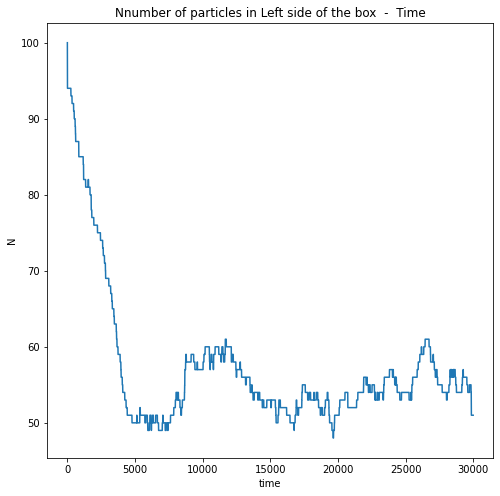

In [31]:
#Time = 30000 ,v_max = 3
#Nnumber of particles in Left side of the box 
time=np.linspace(0,Time,Time) 
fig = plt.figure(figsize=(8,8))
plt.title('Nnumber of particles in Left side of the box  -  Time')
plt.xlabel('time')
plt.ylabel('N')
plt.plot(time,N_L) 

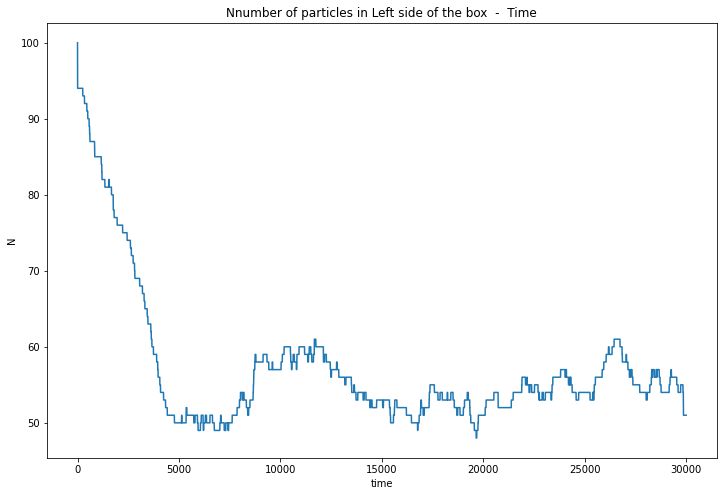

In [54]:
#Time = 30000 ,v_max = 3
#Nnumber of particles in Left side of the box 
time=np.linspace(0,Time,Time) 
fig = plt.figure(figsize=(12,8))
plt.title('Nnumber of particles in Left side of the box  -  Time')
plt.xlabel('time')
plt.ylabel('N')
plt.plot(time,N_L) 

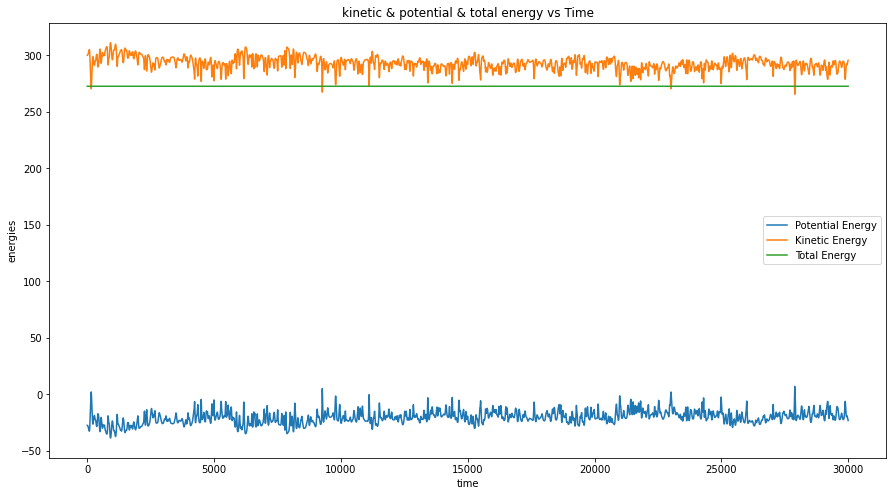

In [32]:
#Time = 30000 , v_max = 3 , h = 10^-3
#energies
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(15,8))
plt.xlabel('time')
plt.ylabel('energies')
plt.title('kinetic & potential & total energy vs Time')
plt.plot(time,Potential_energy[1:], label='Potential Energy')
plt.plot(time,Kinetic_energy[1:], label='Kinetic Energy')
plt.plot(time,Energy[1:], label='Total Energy')
plt.legend()

equilibrium temperature = 351.5256855286141


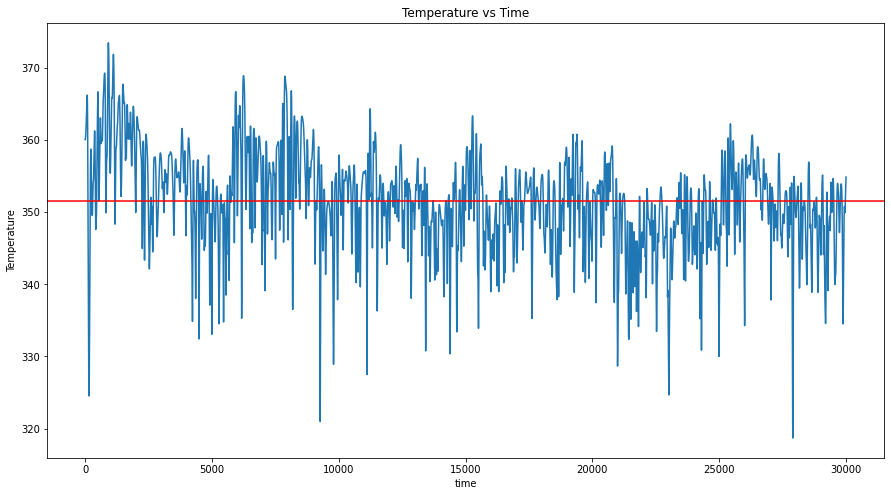

In [42]:
#Time = 30000 , v_max = 3, h = 10^-3
#temperature
Temperature_eq = np.mean(Temperature[1:])
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(15,8))
plt.xlabel('time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time')
plt.plot(time,Temperature[1:])
plt.axhline(y=Temperature_eq,color = 'red')
print('equilibrium temperature =',Temperature_eq)

equilibrium pressure = 49.381906142717


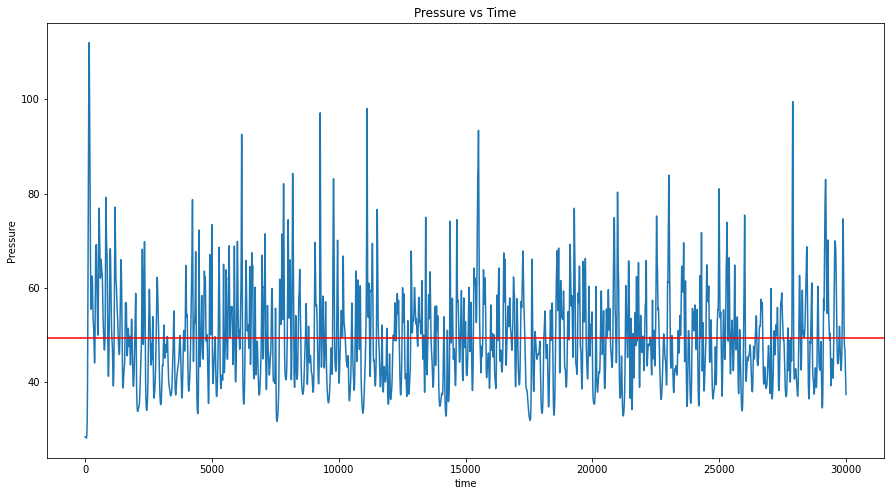

In [43]:
#Time = 30000 , v_max = 3, h = 10^-3
#pressure
Pressure_eq = np.mean(Pressure[1:])
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(15,8))
plt.xlabel('time')
plt.ylabel('Pressure')
plt.title('Pressure vs Time')
plt.plot(time,Pressure[1:])
plt.axhline(y=Pressure_eq,color = 'red')
print('equilibrium pressure =',Pressure_eq)

In [44]:
#velocity_auto correlation
#t = 30,000 & tau = 2000
for i in range(N):
    Correlation_x[i][:] = correlation_function(Velocity_x[i][:],2000)
    Correlation_y[i][:] = correlation_function(Velocity_y[i][:],2000)
    Correlation_t[i][:] = correlation_function(Velocity_t[i][:],2000)

In [45]:
auto_corr_x = Correlation_x.mean(axis=0)
auto_corr_y = Correlation_y.mean(axis=0) 
auto_corr_t = Correlation_t.mean(axis=0) 

In [46]:
auto_corr_x

array([1.        , 1.00891395, 1.00883288, ..., 0.25820008, 0.25805804,
       0.25791598])

In [47]:
auto_corr_y

array([1.        , 1.00833606, 1.00824893, ..., 0.17750609, 0.17735987,
       0.17721374])

In [48]:
auto_corr_t

array([1.        , 1.00315041, 1.00309249, ..., 0.78412138, 0.78405687,
       0.78399236])

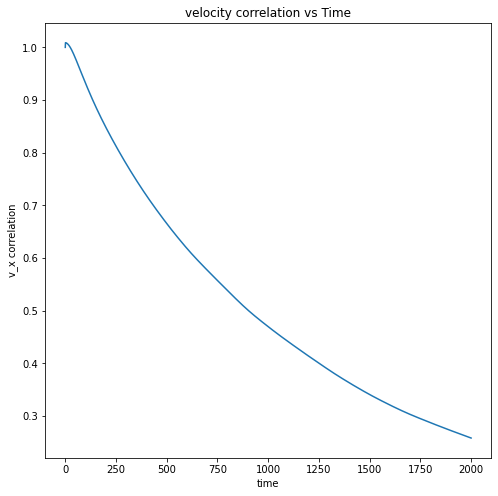

In [49]:
#velocity_auto correlation (v_x)
#t = 30,000 & tau = 2000
time=np.linspace(0,2000,2000) 
fig = plt.figure(figsize=(8,8))
plt.xlabel('time')
plt.ylabel('v_x correlation')
plt.title('velocity correlation vs Time')
plt.plot(time,auto_corr_x) 

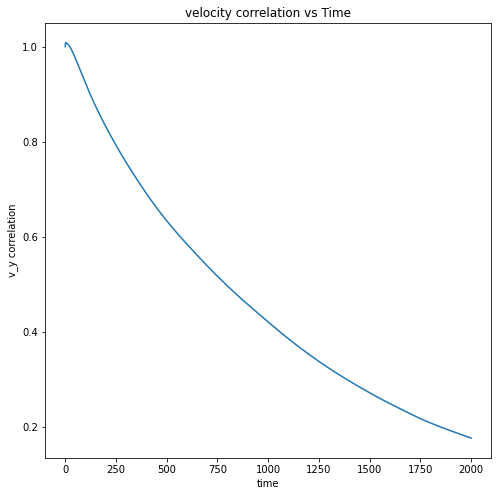

In [50]:
#velocity_auto correlation (v_y)
#t = 30,000 & tau = 2000
time=np.linspace(0,2000,2000) 
fig = plt.figure(figsize=(8,8))
plt.xlabel('time')
plt.ylabel('v_y correlation')
plt.title('velocity correlation vs Time')
plt.plot(time,auto_corr_y) 

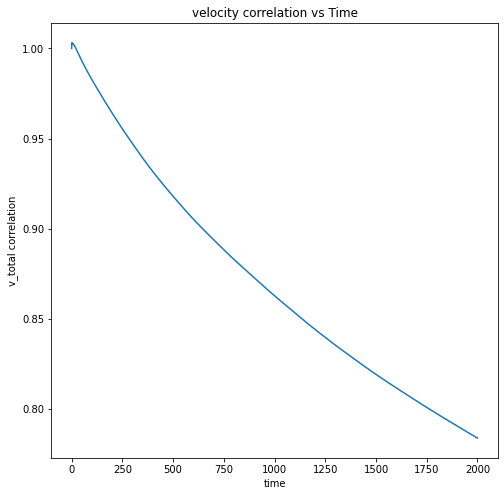

In [51]:
#velocity_auto correlation (v_total)
#t = 30,000 & tau = 2000
time=np.linspace(0,2000,2000) 
fig = plt.figure(figsize=(8,8))
plt.xlabel('time')
plt.ylabel('v_total correlation')
plt.title('velocity correlation vs Time')
plt.plot(time,auto_corr_t) 

In [52]:
def function_fit(x,a,b):
    return ((e ** (x * (-1/a))) * b)

In [59]:
tau = np.arange(0,2000)
popt_correlationx, pcov_correlationx = curve_fit(function_fit,tau,auto_corr_x)
popt_correlationy, pcov_correlationy = curve_fit(function_fit,tau,auto_corr_y)
popt_correlationt, pcov_correlationt = curve_fit(function_fit,tau,auto_corr_t)

In [60]:
popt_correlationx

array([1.40242101e+03, 9.74525571e-01])

In [61]:
popt_correlationy

array([1.14958736e+03, 9.94948280e-01])

In [62]:
popt_correlationt

array([8.32955068e+03, 9.80698510e-01])

In [66]:
system_correlation_length = popt_correlationt[0]
system_correlation_length

8329.55068221609

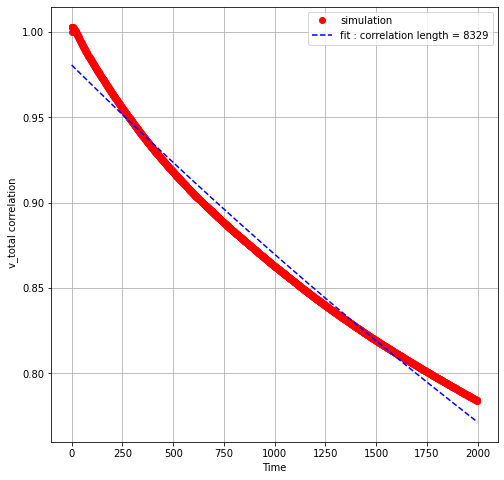

In [64]:
#plot for correlation length
fig = plt.figure(figsize=(8,8))
co_fit = (e ** (tau * (-1/popt_correlationt[0]))) * popt_correlationt[1]
plt.plot(tau,auto_corr_t,'ro')
plt.plot(tau,co_fit,'b--')
plt.grid()
plt.xlabel('Time')
plt.ylabel(' v_total correlation')
plt.legend(('simulation','fit : correlation length = 8330'))

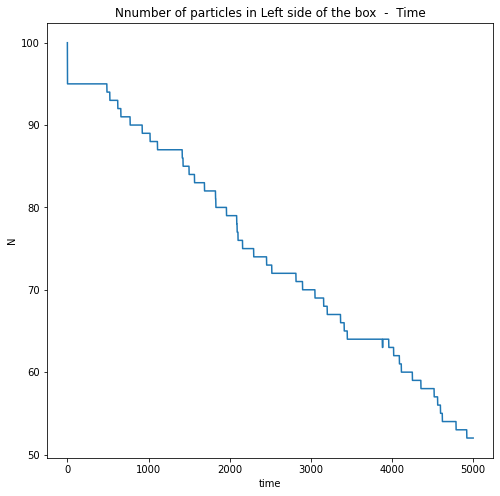

In [72]:
#Time = 5000 ,v_max = 3 , h = 10^-3
#Nnumber of particles in Left side of the box 
time=np.linspace(0,Time,Time) 
fig = plt.figure(figsize=(8,8))
plt.title('Nnumber of particles in Left side of the box  -  Time')
plt.xlabel('time')
plt.ylabel('N')
plt.plot(time,N_L) 

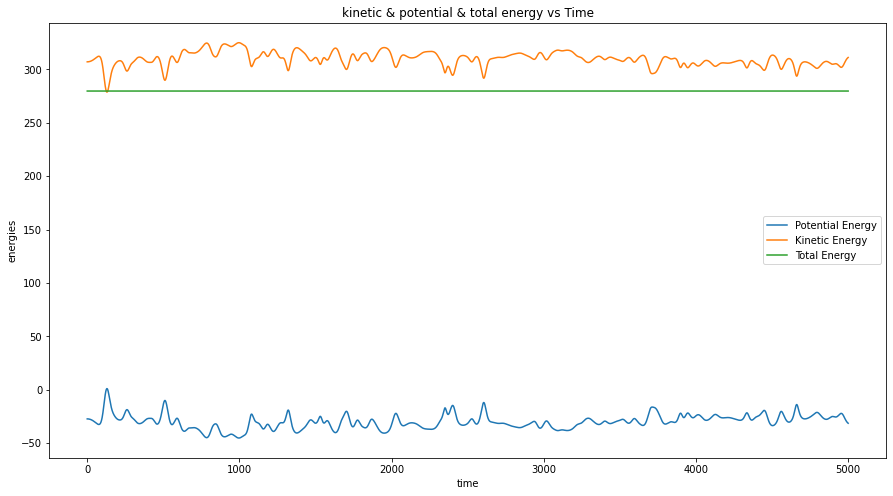

In [73]:
#Time = 5000 , v_max = 3 , h = 10^-3
#energies
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(15,8))
plt.xlabel('time')
plt.ylabel('energies')
plt.title('kinetic & potential & total energy vs Time')
plt.plot(time,Potential_energy[1:], label='Potential Energy')
plt.plot(time,Kinetic_energy[1:], label='Kinetic Energy')
plt.plot(time,Energy[1:], label='Total Energy')
plt.legend()

equilibrium temperature = 371.60594537589003


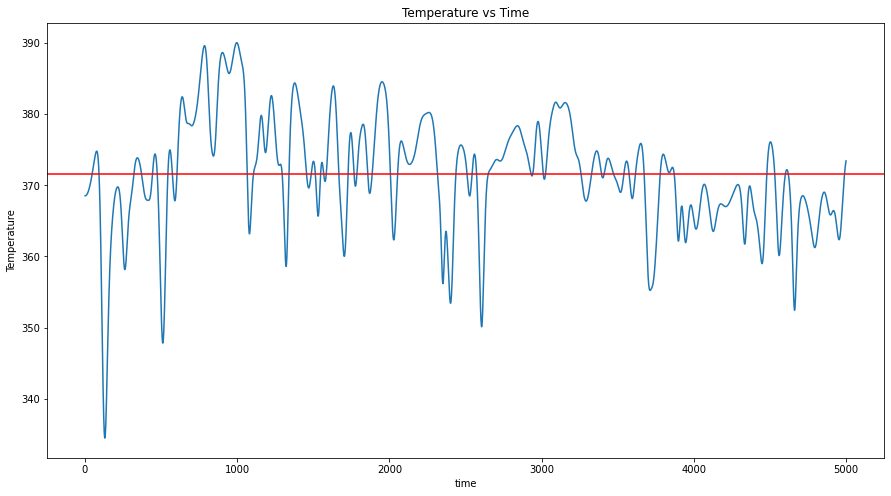

In [74]:
#Time = 5000 , v_max = 3, h = 10^-3
#temperature
Temperature_eq = np.mean(Temperature[1:])
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(15,8))
plt.xlabel('time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time')
plt.plot(time,Temperature[1:])
plt.axhline(y=Temperature_eq,color = 'red')
print('equilibrium temperature =',Temperature_eq)

equilibrium pressure = 53.39593170982982


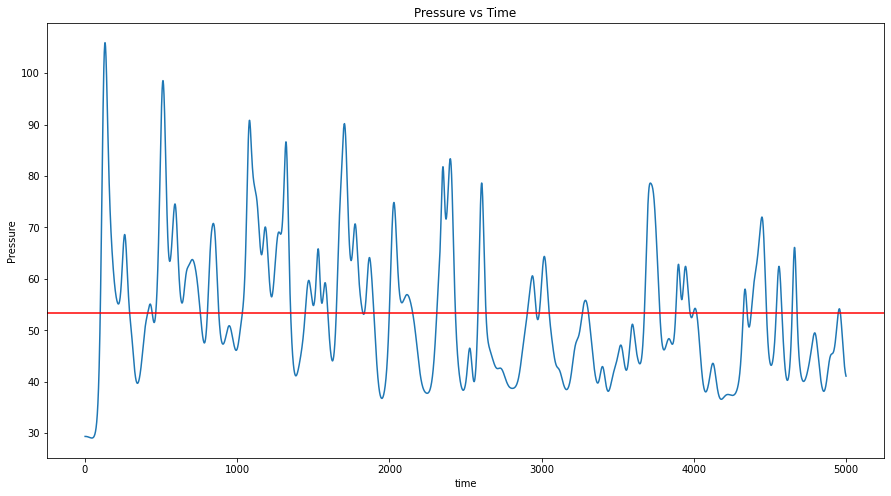

In [75]:
#Time = 5000 , v_max = 3, h = 10^-3
#pressure
Pressure_eq = np.mean(Pressure[1:])
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(15,8))
plt.xlabel('time')
plt.ylabel('Pressure')
plt.title('Pressure vs Time')
plt.plot(time,Pressure[1:])
plt.axhline(y=Pressure_eq,color = 'red')
print('equilibrium pressure =',Pressure_eq)

In [76]:
#velocity_auto correlation
#t = 5000 & tau = 500
for i in range(N):
    Correlation_x[i][:] = correlation_function(Velocity_x[i][:],500)
    Correlation_y[i][:] = correlation_function(Velocity_y[i][:],500)
    Correlation_t[i][:] = correlation_function(Velocity_t[i][:],500)

In [79]:
auto_corr_x = Correlation_x.mean(axis=0)
auto_corr_y = Correlation_y.mean(axis=0) 
auto_corr_t = Correlation_t.mean(axis=0) 

In [82]:
auto_corr_t

array([1.        , 0.99870875, 0.99846535, 0.9982063 , 0.99793195,
       0.99764271, 0.99733909, 0.9970216 , 0.99669085, 0.99634745,
       0.99599203, 0.99562527, 0.99524781, 0.99486033, 0.9944635 ,
       0.99405797, 0.99364439, 0.99322339, 0.99279559, 0.99236157,
       0.9919219 , 0.99147712, 0.99102776, 0.99057431, 0.99011722,
       0.98965695, 0.98919389, 0.98872844, 0.98826095, 0.98779176,
       0.98732118, 0.98684948, 0.98637694, 0.98590379, 0.98543025,
       0.98495653, 0.98448279, 0.98400921, 0.98353594, 0.98306309,
       0.9825908 , 0.98211916, 0.98164826, 0.98117818, 0.98070899,
       0.98024075, 0.97977351, 0.9793073 , 0.97884217, 0.97837815,
       0.97791524, 0.97745348, 0.97699286, 0.9765334 , 0.97607511,
       0.97561797, 0.97516198, 0.97470714, 0.97425344, 0.97380087,
       0.97334941, 0.97289906, 0.97244979, 0.97200159, 0.97155444,
       0.97110832, 0.97066323, 0.97021913, 0.96977602, 0.96933388,
       0.96889269, 0.96845244, 0.96801311, 0.96757469, 0.96713

In [84]:
auto_corr_x

array([1.        , 1.01294349, 1.01263392, 1.01228983, 1.01191133,
       1.01149857, 1.01105173, 1.01057106, 1.01005681, 1.00950929,
       1.00892885, 1.00831585, 1.00767072, 1.00699388, 1.00628582,
       1.00554702, 1.004778  , 1.00397933, 1.00315156, 1.00229527,
       1.00141108, 1.00049961, 0.99956148, 0.99859733, 0.99760783,
       0.99659364, 0.99555542, 0.99449384, 0.99340958, 0.99230331,
       0.99117571, 0.99002746, 0.98885922, 0.98767166, 0.98646545,
       0.98524124, 0.98399968, 0.98274142, 0.98146709, 0.9801773 ,
       0.97887269, 0.97755385, 0.97622138, 0.97487586, 0.97351787,
       0.97214797, 0.97076669, 0.96937459, 0.96797219, 0.96656   ,
       0.96513852, 0.96370823, 0.96226962, 0.96082314, 0.95936926,
       0.9579084 , 0.95644099, 0.95496746, 0.95348819, 0.9520036 ,
       0.95051404, 0.9490199 , 0.94752154, 0.94601929, 0.9445135 ,
       0.94300449, 0.94149258, 0.93997808, 0.93846128, 0.93694247,
       0.93542193, 0.93389993, 0.93237674, 0.93085259, 0.92932

In [85]:
auto_corr_y 

array([1.        , 1.03483277, 1.03451746, 1.03415844, 1.03375584,
       1.03330989, 1.03282084, 1.03228903, 1.03171482, 1.03109866,
       1.03044101, 1.02974241, 1.02900342, 1.02822467, 1.02740682,
       1.02655055, 1.0256566 , 1.02472574, 1.02375874, 1.02275644,
       1.02171966, 1.02064928, 1.01954616, 1.01841121, 1.01724533,
       1.01604943, 1.01482443, 1.01357126, 1.01229085, 1.01098411,
       1.00965198, 1.00829537, 1.0069152 , 1.00551237, 1.00408778,
       1.0026423 , 1.00117682, 0.99969218, 0.99818924, 0.99666881,
       0.99513172, 0.99357875, 0.99201068, 0.99042827, 0.98883225,
       0.98722335, 0.98560225, 0.98396966, 0.98232621, 0.98067256,
       0.97900933, 0.97733711, 0.97565648, 0.97396801, 0.97227225,
       0.97056971, 0.96886089, 0.9671463 , 0.96542639, 0.96370162,
       0.96197242, 0.9602392 , 0.95850238, 0.95676233, 0.95501943,
       0.95327403, 0.95152646, 0.94977707, 0.94802615, 0.94627401,
       0.94452094, 0.9427672 , 0.94101307, 0.93925879, 0.93750

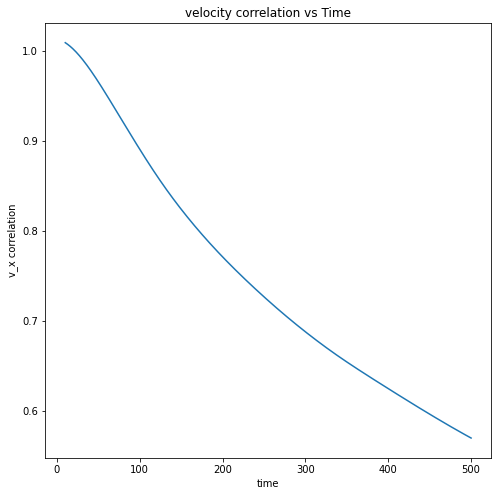

In [88]:
#velocity_auto correlation (v_x)
#t = 5000 & tau = 500
time=np.linspace(10,500,490) 
fig = plt.figure(figsize=(8,8))
plt.xlabel('time')
plt.ylabel('v_x correlation')
plt.title('velocity correlation vs Time')
plt.plot(time,auto_corr_x[10:]) 

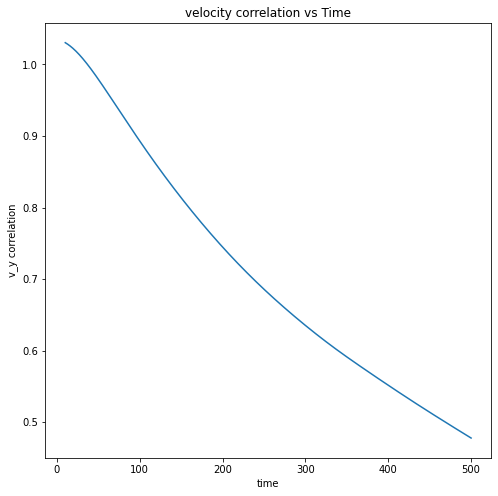

In [87]:
#velocity_auto correlation (v_y)
#t = 50000 & tau = 500
time=np.linspace(10,500,490) 
fig = plt.figure(figsize=(8,8))
plt.xlabel('time')
plt.ylabel('v_y correlation')
plt.title('velocity correlation vs Time')
plt.plot(time,auto_corr_y[10:]) 

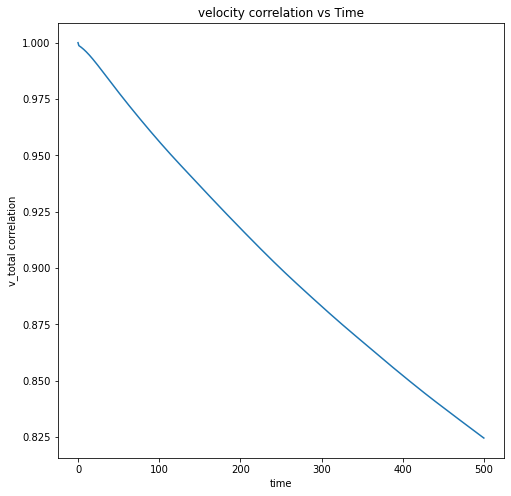

In [89]:
#velocity_auto correlation (v_total)
#t = 5000 & tau = 500
time=np.linspace(0,500,500) 
fig = plt.figure(figsize=(8,8))
plt.xlabel('time')
plt.ylabel('v_total correlation')
plt.title('velocity correlation vs Time')
plt.plot(time,auto_corr_t) 

In [91]:
tau = np.arange(0,500)
popt_correlationx, pcov_correlationx = curve_fit(function_fit,tau,auto_corr_x)
popt_correlationy, pcov_correlationy = curve_fit(function_fit,tau,auto_corr_y)
popt_correlationt, pcov_correlationt = curve_fit(function_fit,tau,auto_corr_t)

In [92]:
popt_correlationt

array([2.57759364e+03, 9.94428679e-01])

In [93]:
system_correlation_length = popt_correlationt[0]
system_correlation_length

2577.5936364684303

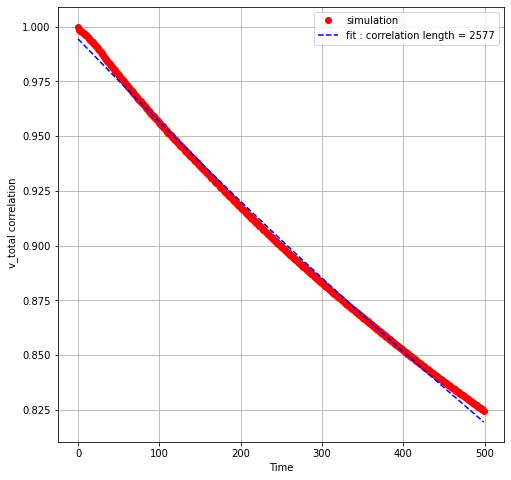

In [94]:
#plot for correlation length
fig = plt.figure(figsize=(8,8))
co_fit = (e ** (tau * (-1/popt_correlationt[0]))) * popt_correlationt[1]
plt.plot(tau,auto_corr_t,'ro')
plt.plot(tau,co_fit,'b--')
plt.grid()
plt.xlabel('Time')
plt.ylabel(' v_total correlation')
plt.legend(('simulation','fit : correlation length = 2577'))

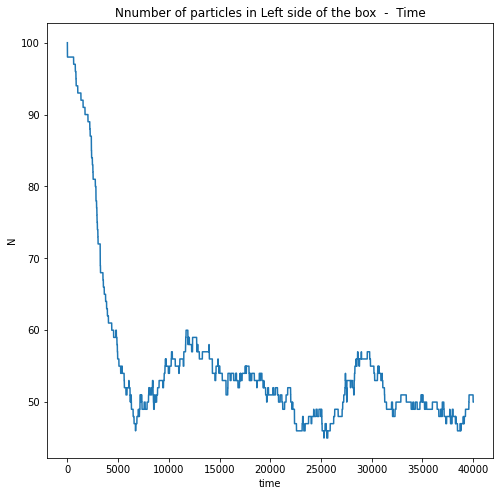

In [159]:
#Time = 40000 ,v_max = 3
#Nnumber of particles in Left side of the box 
time=np.linspace(0,Time,Time) 
fig = plt.figure(figsize=(8,8))
plt.title('Nnumber of particles in Left side of the box  -  Time')
plt.xlabel('time')
plt.ylabel('N')
plt.plot(time,N_L) 

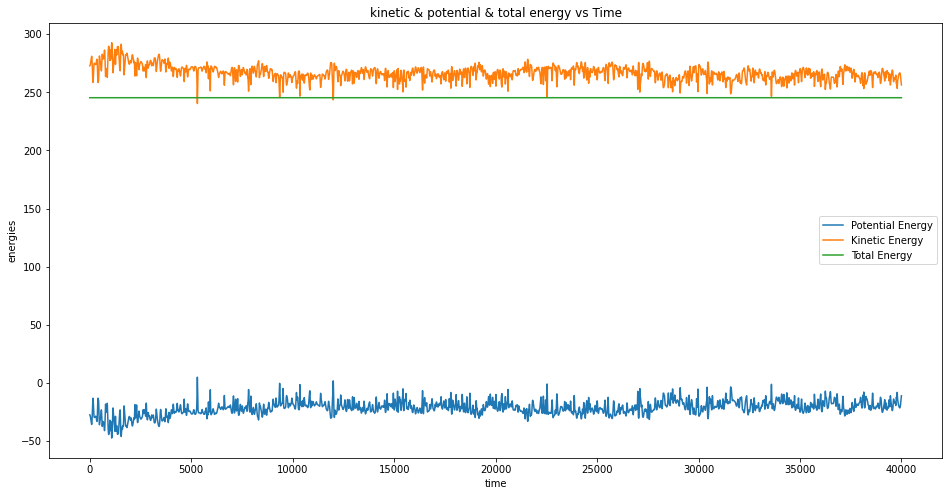

In [163]:
#Time = 40000 , v_max = 3
#energies
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(16,8))
plt.xlabel('time')
plt.ylabel('energies')
plt.title('kinetic & potential & total energy vs Time')
plt.plot(time,Potential_energy[1:], label='Potential Energy')
plt.plot(time,Kinetic_energy[1:], label='Kinetic Energy')
plt.plot(time,Energy[1:], label='Total Energy')
plt.legend()

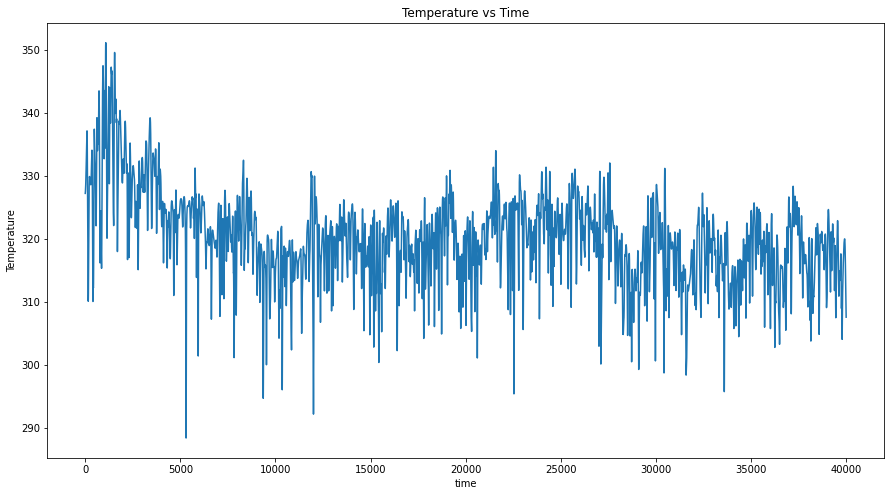

In [161]:
#Time = 40000 , v_max = 3
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(15,8))
plt.xlabel('time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time')
plt.plot(time,Temperature[1:])

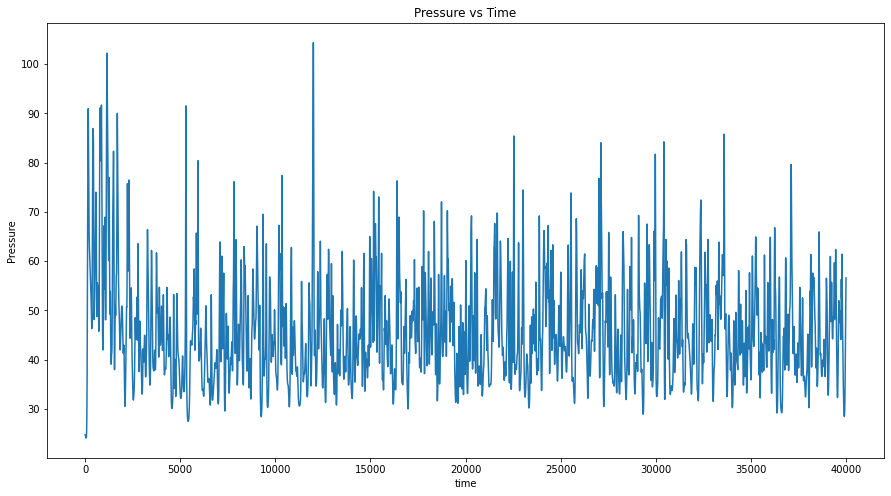

In [162]:
#Time = 40000 , v_max = 3
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(15,8))
plt.xlabel('time')
plt.ylabel('Pressure')
plt.title('Pressure vs Time')
plt.plot(time,Pressure[1:])

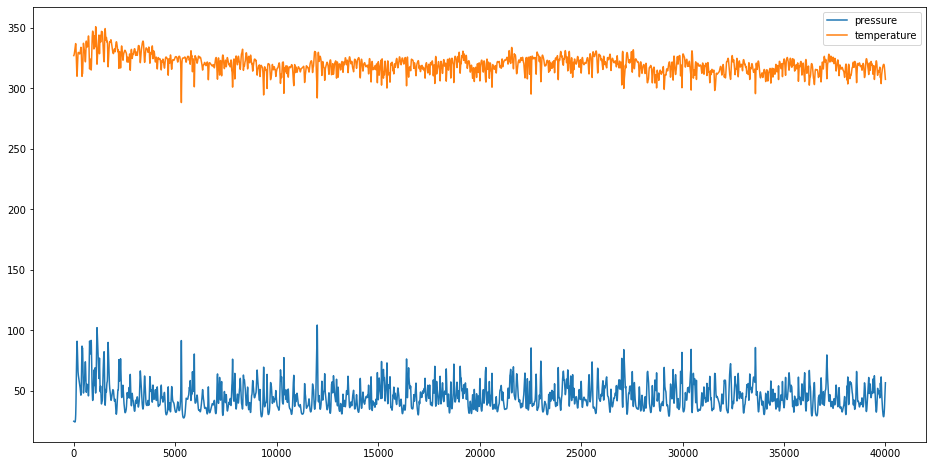

In [165]:
#Time = 40000, h = 10^-3 , v_maax = 3
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(16,8))
plt.plot(time,Pressure[1:],label='pressure')
plt.plot(time,Temperature[1:],label='temperature')
plt.legend()

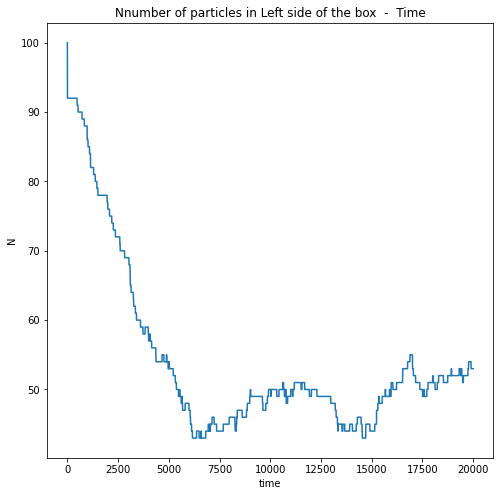

In [124]:
#Time = 20000
#Nnumber of particles in Left side of the box 
time=np.linspace(0,Time,Time) 
fig = plt.figure(figsize=(8,8))
plt.title('Nnumber of particles in Left side of the box  -  Time')
plt.xlabel('time')
plt.ylabel('N')
plt.plot(time,N_L) 

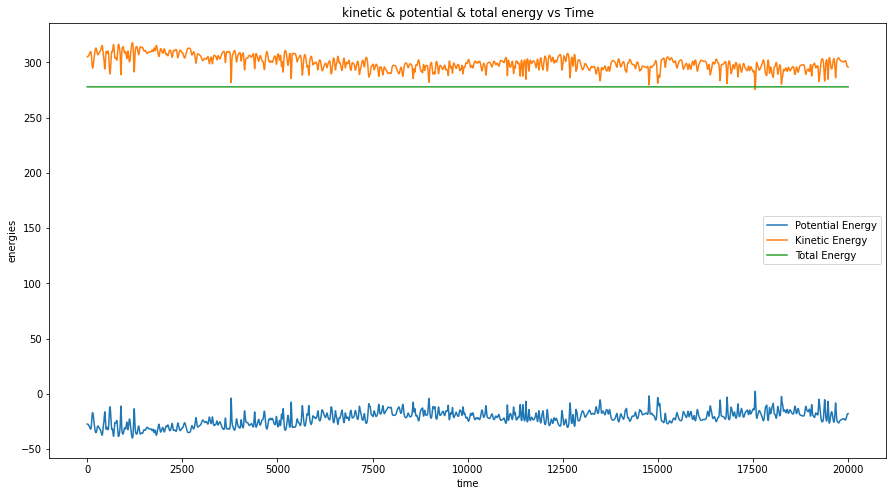

In [125]:
#Time = 20000
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(15,8))
plt.xlabel('time')
plt.ylabel('energies')
plt.title('kinetic & potential & total energy vs Time')
plt.plot(time,Potential_energy[1:], label='Potential Energy')
plt.plot(time,Kinetic_energy[1:], label='Kinetic Energy')
plt.plot(time,Energy[1:], label='Total Energy')
plt.legend()

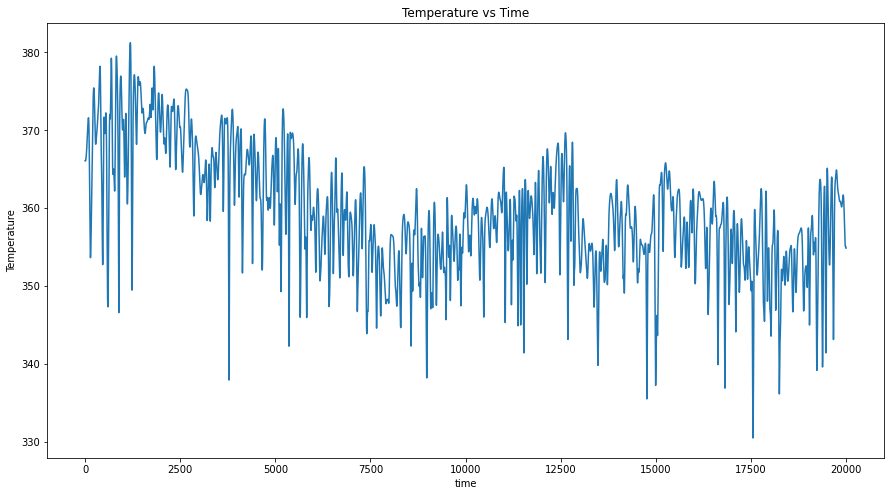

In [126]:
#Time = 20000
T = 120*(Kinetic_energy[1:])/N
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(15,8))
plt.xlabel('time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time')
plt.plot(time,Temperature[1:])

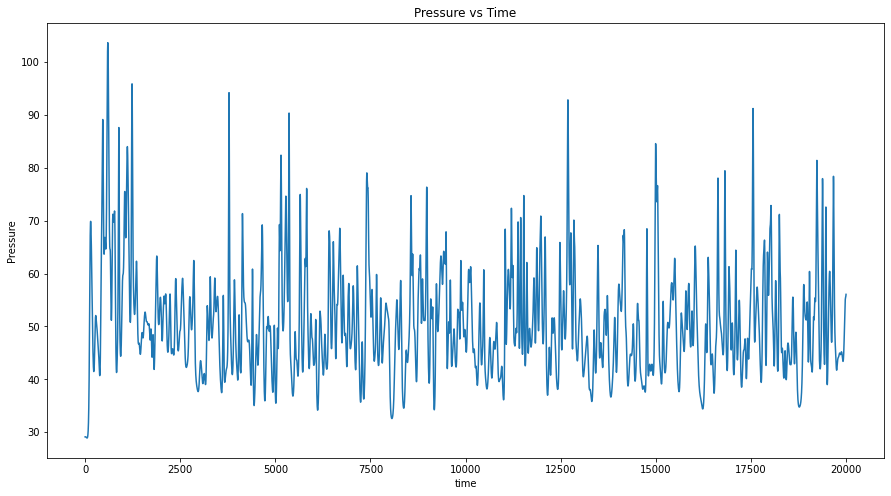

In [128]:
#Time = 20000
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(15,8))
plt.xlabel('time')
plt.ylabel('Pressure')
plt.title('Pressure vs Time')
plt.plot(time,Pressure[1:])

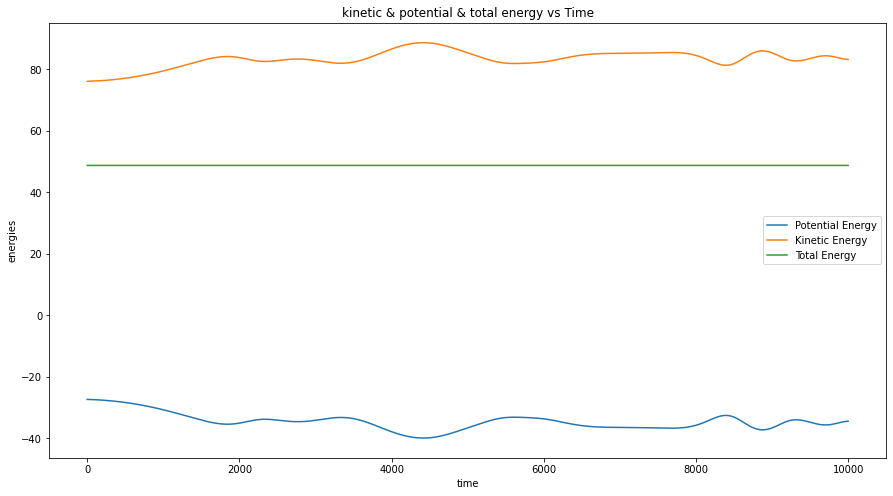

In [150]:
#Time = 10000, h = 10^-4 , v_maax = 1.5
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(15,8))
plt.xlabel('time')
plt.ylabel('energies')
plt.title('kinetic & potential & total energy vs Time')
plt.plot(time,Potential_energy[1:], label='Potential Energy')
plt.plot(time,Kinetic_energy[1:], label='Kinetic Energy')
plt.plot(time,Energy[1:], label='Total Energy')
plt.legend()

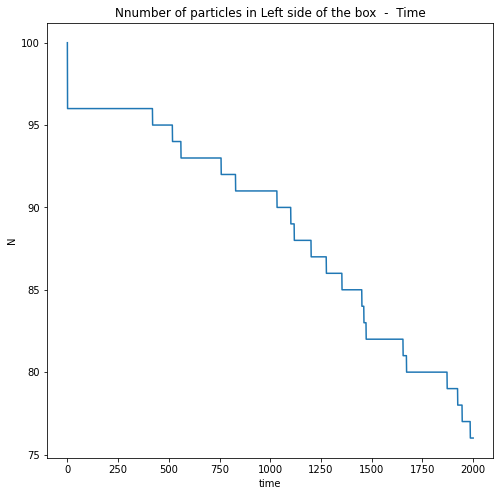

In [111]:
#Time = 2000 ,v_max = 3 , h = 10^-3
#Nnumber of particles in Left side of the box 
time=np.linspace(0,Time,Time) 
fig = plt.figure(figsize=(8,8))
plt.title('Nnumber of particles in Left side of the box  -  Time')
plt.xlabel('time')
plt.ylabel('N')
plt.plot(time,N_L) 

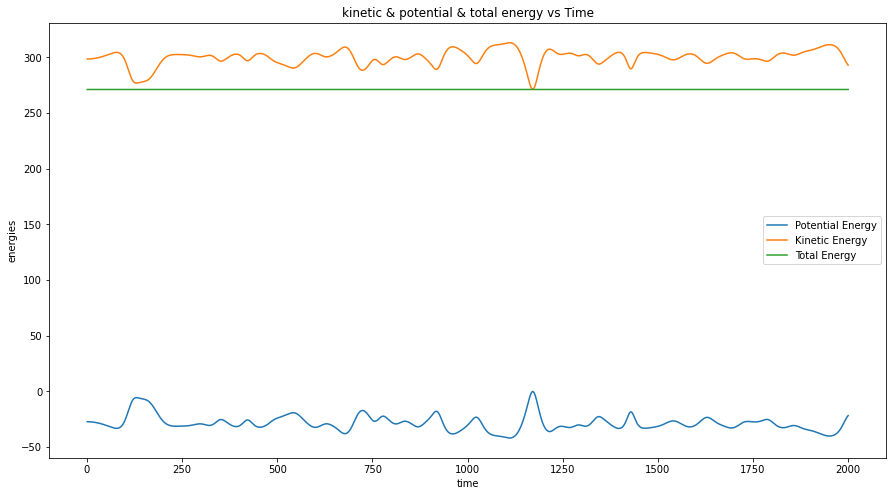

In [112]:
#Time = 2000 , v_max = 3 , h = 10^-3
#energies
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(15,8))
plt.xlabel('time')
plt.ylabel('energies')
plt.title('kinetic & potential & total energy vs Time')
plt.plot(time,Potential_energy[1:], label='Potential Energy')
plt.plot(time,Kinetic_energy[1:], label='Kinetic Energy')
plt.plot(time,Energy[1:], label='Total Energy')
plt.legend()

equilibrium temperature = 359.72279555536517


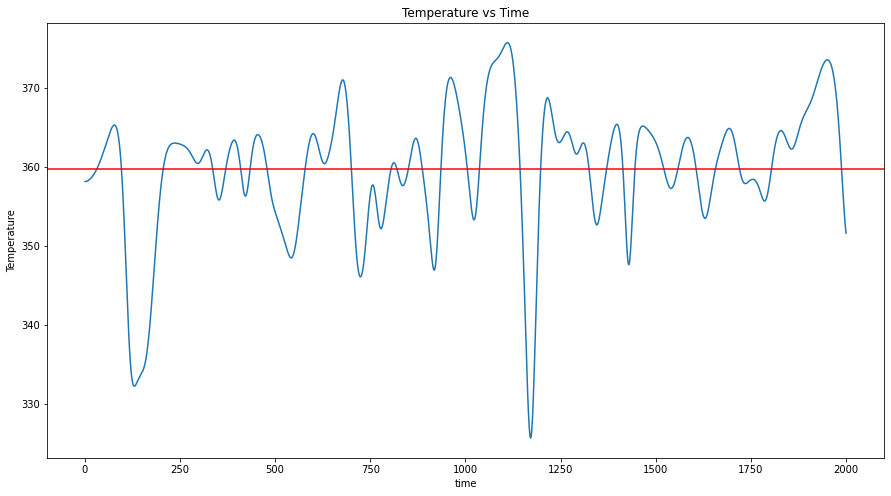

In [116]:
#Time = 2000 , v_max = 3, h = 10^-3
#temperature
Temperature_eq = np.mean(Temperature[1:])
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(15,8))
plt.xlabel('time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time')
plt.plot(time,Temperature[1:])
plt.axhline(y=Temperature_eq,color = 'red')
print('equilibrium temperature =',Temperature_eq)

equilibrium pressure = 59.190846766836806


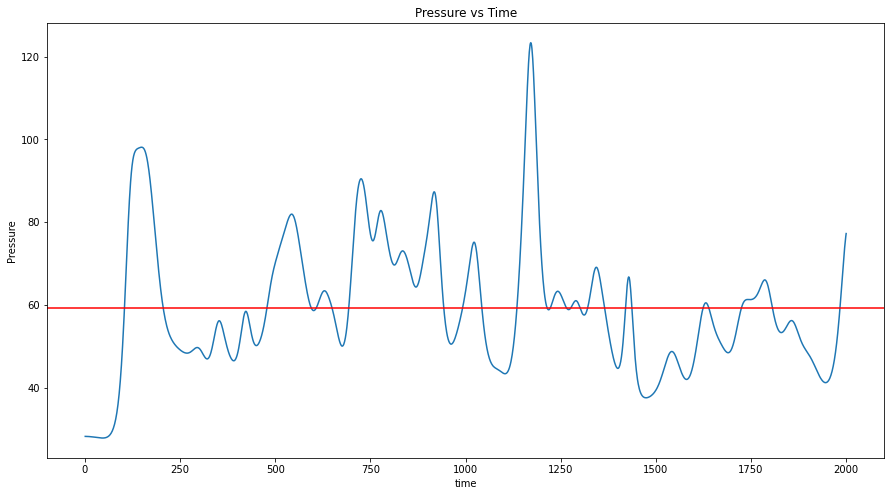

In [117]:
#Time = 2000 , v_max = 3, h = 10^-3
#pressure
Pressure_eq = np.mean(Pressure[1:])
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(15,8))
plt.xlabel('time')
plt.ylabel('Pressure')
plt.title('Pressure vs Time')
plt.plot(time,Pressure[1:])
plt.axhline(y=Pressure_eq,color = 'red')
print('equilibrium pressure =',Pressure_eq)

In [118]:
#velocity_auto correlation
#t = 2000 & tau = 200
for i in range(N):
    Correlation_x[i][:] = correlation_function(Velocity_x[i][:],200)
    Correlation_y[i][:] = correlation_function(Velocity_y[i][:],200)
    Correlation_t[i][:] = correlation_function(Velocity_t[i][:],200)

In [119]:
auto_corr_x = Correlation_x.mean(axis=0)
auto_corr_y = Correlation_y.mean(axis=0) 
auto_corr_t = Correlation_t.mean(axis=0) 

In [120]:
auto_corr_t

array([1.        , 1.01374723, 1.01309975, 1.01242995, 1.01173833,
       1.01102552, 1.01029226, 1.00953937, 1.00876773, 1.00797829,
       1.00717203, 1.00634995, 1.00551305, 1.00466237, 1.00379892,
       1.00292367, 1.00203762, 1.0011417 , 1.00023684, 0.99932391,
       0.99840376, 0.99747719, 0.99654498, 0.99560784, 0.99466646,
       0.99372148, 0.9927735 , 0.99182308, 0.99087076, 0.98991701,
       0.98896227, 0.98800697, 0.98705148, 0.98609614, 0.98514126,
       0.98418713, 0.98323398, 0.98228206, 0.98133155, 0.98038263,
       0.97943544, 0.97849012, 0.97754677, 0.97660548, 0.97566632,
       0.97472934, 0.97379459, 0.97286208, 0.97193184, 0.97100387,
       0.97007815, 0.96915467, 0.96823342, 0.96731434, 0.96639742,
       0.9654826 , 0.96456983, 0.96365908, 0.96275028, 0.96184337,
       0.96093832, 0.96003504, 0.9591335 , 0.95823363, 0.95733538,
       0.9564387 , 0.95554354, 0.95464985, 0.95375758, 0.95286671,
       0.95197719, 0.95108898, 0.95020207, 0.94931643, 0.94843

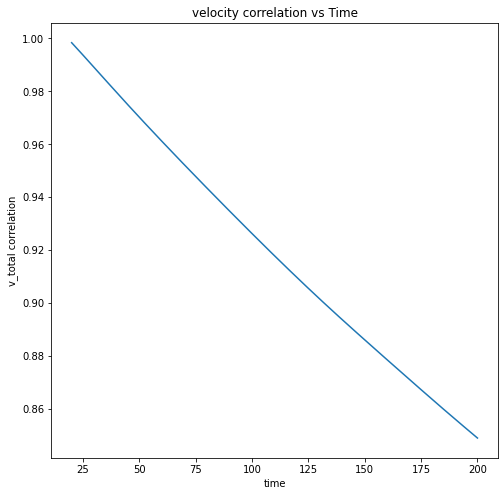

In [122]:
#velocity_auto correlation (v_total)
#t = 2000 & tau = 200
time=np.linspace(20,200,180) 
fig = plt.figure(figsize=(8,8))
plt.xlabel('time')
plt.ylabel('v_total correlation')
plt.title('velocity correlation vs Time')
plt.plot(time,auto_corr_t[20:]) 

In [123]:
tau = np.arange(0,200)
popt_correlationx, pcov_correlationx = curve_fit(function_fit,tau,auto_corr_x)
popt_correlationy, pcov_correlationy = curve_fit(function_fit,tau,auto_corr_y)
popt_correlationt, pcov_correlationt = curve_fit(function_fit,tau,auto_corr_t)

In [124]:
system_correlation_length = popt_correlationt[0]
system_correlation_length

1100.615917311611

In [126]:
popt_correlationt

array([1.10061592e+03, 1.01501355e+00])

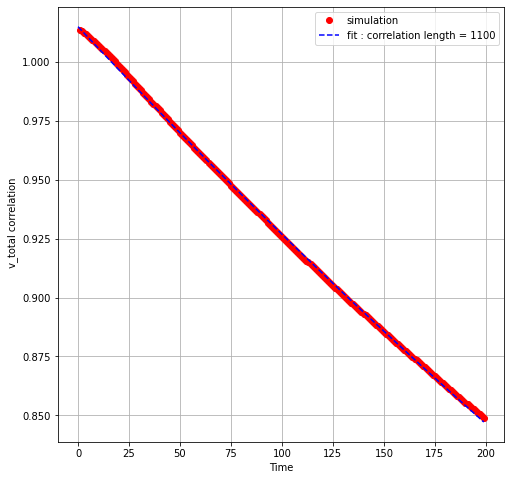

In [127]:
#plot for correlation length
fig = plt.figure(figsize=(8,8))
co_fit = (e ** (tau * (-1/popt_correlationt[0]))) * popt_correlationt[1]
plt.plot(tau[1:],auto_corr_t[1:],'ro')
plt.plot(tau,co_fit,'b--')
plt.grid()
plt.xlabel('Time')
plt.ylabel(' v_total correlation')
plt.legend(('simulation','fit : correlation length = 1100'))

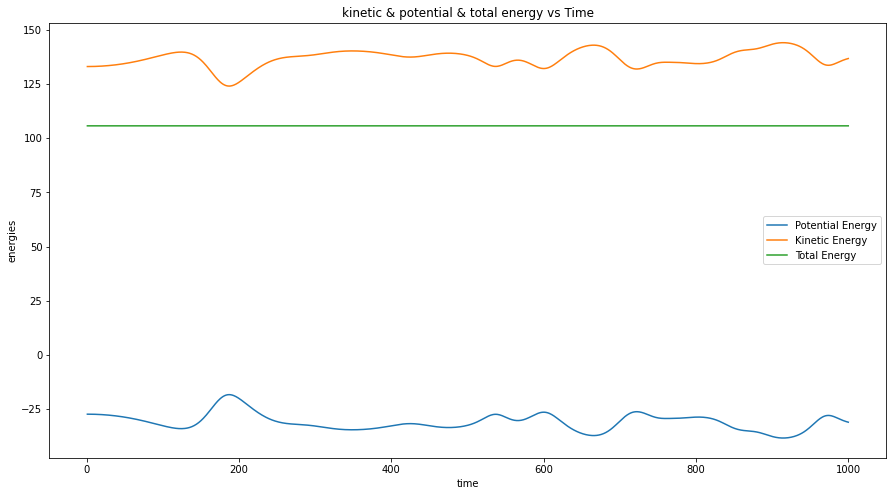

In [132]:
#Time = 1000 , v_max = 2 , h = 10^-3
#energies
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(15,8))
plt.xlabel('time')
plt.ylabel('energies')
plt.title('kinetic & potential & total energy vs Time')
plt.plot(time,Potential_energy[1:], label='Potential Energy')
plt.plot(time,Kinetic_energy[1:], label='Kinetic Energy')
plt.plot(time,Energy[1:], label='Total Energy')
plt.legend()

equilibrium temperature = 163.9895367028659


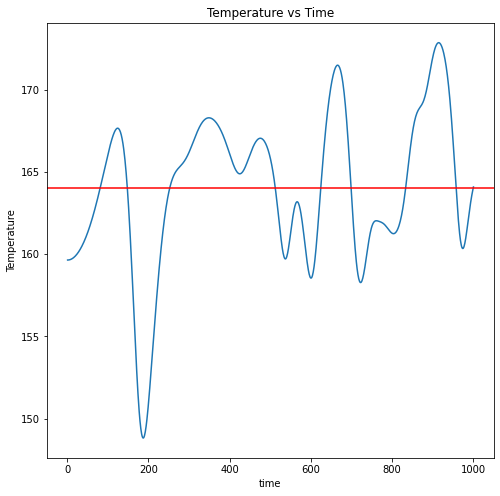

In [136]:
#Time = 1000 , v_max = 2, h = 10^-3
#temperature
Temperature_eq = np.mean(Temperature[1:])
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(8,8))
plt.xlabel('time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time')
plt.plot(time,Temperature[1:])
plt.axhline(y=Temperature_eq,color = 'red')
print('equilibrium temperature =',Temperature_eq)

equilibrium pressure = 25.64671055614585


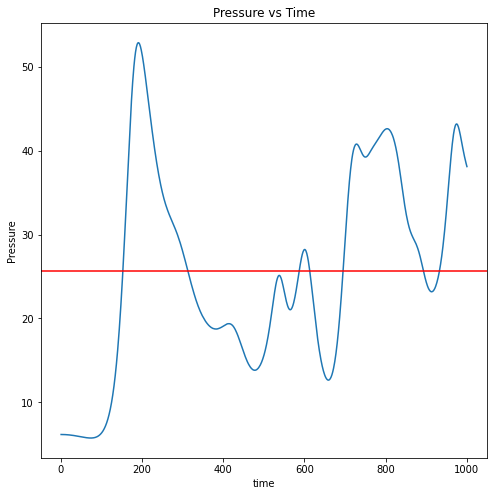

In [138]:
#Time = 1000 , v_max = 2, h = 10^-3
#pressure
Pressure_eq = np.mean(Pressure[1:])
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(8,8))
plt.xlabel('time')
plt.ylabel('Pressure')
plt.title('Pressure vs Time')
plt.plot(time,Pressure[1:])
plt.axhline(y=Pressure_eq,color = 'red')
print('equilibrium pressure =',Pressure_eq)

In [139]:
#velocity_auto correlation
#t = 1000 & tau = 100
for i in range(N):
    Correlation_x[i][:] = correlation_function(Velocity_x[i][:],100)
    Correlation_y[i][:] = correlation_function(Velocity_y[i][:],100)
    Correlation_t[i][:] = correlation_function(Velocity_t[i][:],100)

In [140]:
auto_corr_x = Correlation_x.mean(axis=0)
auto_corr_y = Correlation_y.mean(axis=0) 
auto_corr_t = Correlation_t.mean(axis=0) 

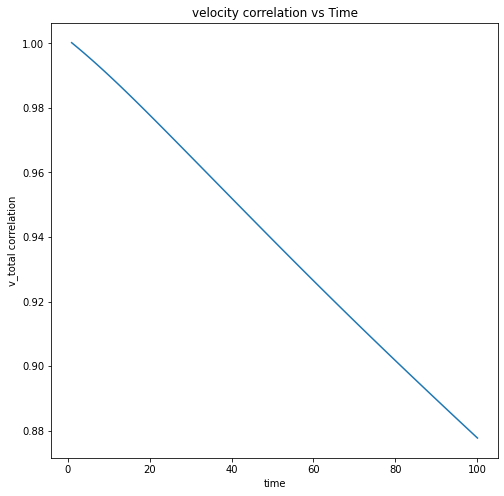

In [144]:
#velocity_auto correlation (v_total)
#t = 2000 & tau = 200
time=np.linspace(1,100,99) 
fig = plt.figure(figsize=(8,8))
plt.xlabel('time')
plt.ylabel('v_total correlation')
plt.title('velocity correlation vs Time')
plt.plot(time,auto_corr_t[1:]) 

In [145]:
tau = np.arange(0,100)
popt_correlationx, pcov_correlationx = curve_fit(function_fit,tau,auto_corr_x)
popt_correlationy, pcov_correlationy = curve_fit(function_fit,tau,auto_corr_y)
popt_correlationt, pcov_correlationt = curve_fit(function_fit,tau,auto_corr_t)

In [146]:
system_correlation_length = popt_correlationt[0]
system_correlation_length

740.7723725053731

In [147]:
popt_correlationt

array([740.77237251,   1.00370248])

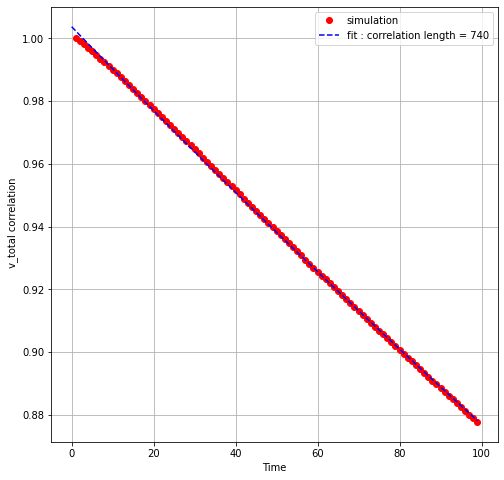

In [148]:
#plot for correlation length
fig = plt.figure(figsize=(8,8))
co_fit = (e ** (tau * (-1/popt_correlationt[0]))) * popt_correlationt[1]
plt.plot(tau[1:],auto_corr_t[1:],'ro')
plt.plot(tau,co_fit,'b--')
plt.grid()
plt.xlabel('Time')
plt.ylabel(' v_total correlation')
plt.legend(('simulation','fit : correlation length = 740'))

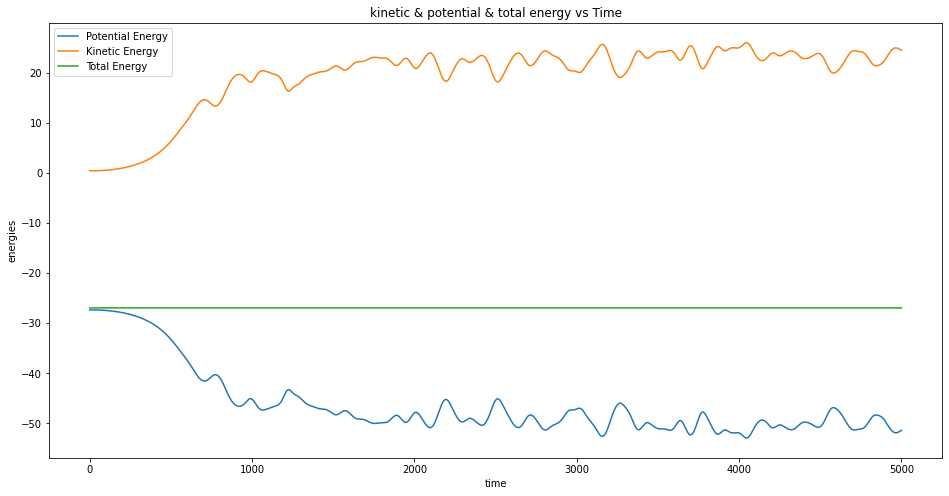

In [154]:
#Time = 5000 , v_max = 0.108 #liquid
#energies
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(16,8))
plt.xlabel('time')
plt.ylabel('energies')
plt.title('kinetic & potential & total energy vs Time')
plt.plot(time,Potential_energy[1:], label='Potential Energy')
plt.plot(time,Kinetic_energy[1:], label='Kinetic Energy')
plt.plot(time,Energy[1:], label='Total Energy')
plt.legend()

equilibrium temperature = 23.254627349165023


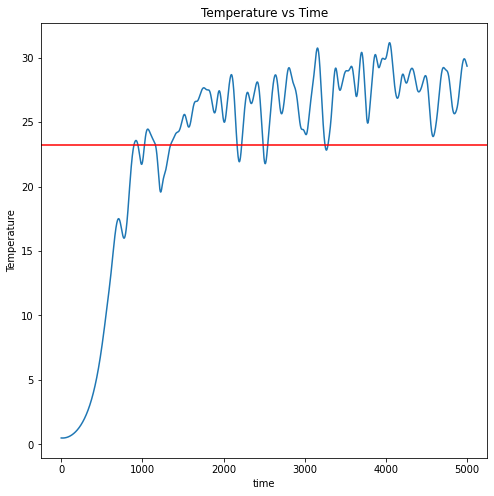

In [155]:
#Time = 5000 , v_max = 0.108, h = 10^-3 #liquid
#temperature
Temperature_eq = np.mean(Temperature[1:])
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(8,8))
plt.xlabel('time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time')
plt.plot(time,Temperature[1:])
plt.axhline(y=Temperature_eq,color = 'red')
print('equilibrium temperature =',Temperature_eq)

equilibrium pressure = 2.7185950599455584


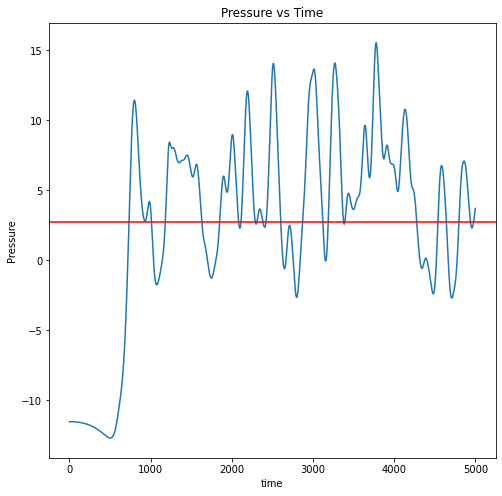

In [156]:
#Time = 5000 , v_max = 0.108, h = 10^-3 #liquid
#pressure
Pressure_eq = np.mean(Pressure[1:])
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(8,8))
plt.xlabel('time')
plt.ylabel('Pressure')
plt.title('Pressure vs Time')
plt.plot(time,Pressure[1:])
plt.axhline(y=Pressure_eq,color = 'red')
print('equilibrium pressure =',Pressure_eq)

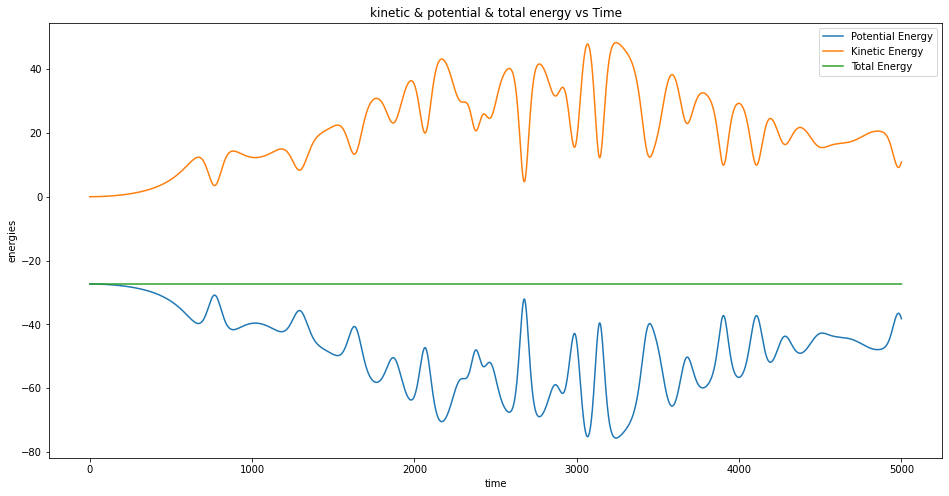

In [160]:
#Time = 5000 , v_max = 0.00000001 #solid
#energies
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(16,8))
plt.xlabel('time')
plt.ylabel('energies')
plt.title('kinetic & potential & total energy vs Time')
plt.plot(time,Potential_energy[1:], label='Potential Energy')
plt.plot(time,Kinetic_energy[1:], label='Kinetic Energy')
plt.plot(time,Energy[1:], label='Total Energy')
plt.legend()

equilibrium temperature = 25.089998512874566


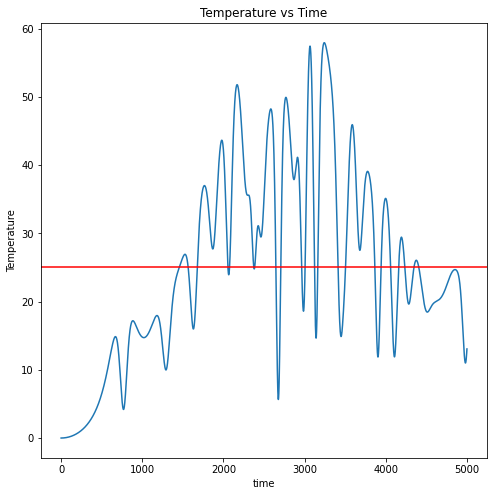

In [161]:
#Time = 5000 , v_max = 0.00000001 #solid
#temperature
Temperature_eq = np.mean(Temperature[1:])
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(8,8))
plt.xlabel('time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time')
plt.plot(time,Temperature[1:])
plt.axhline(y=Temperature_eq,color = 'red')
print('equilibrium temperature =',Temperature_eq)

equilibrium pressure = 5.1686522984706995


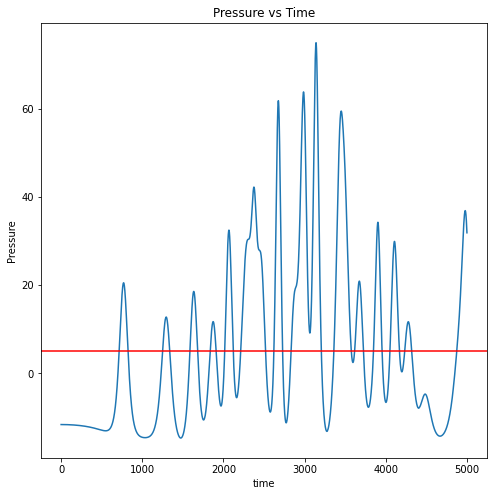

In [162]:
#Time = 5000 ,  v_max = 0.00000001 #solid
#pressure
Pressure_eq = np.mean(Pressure[1:])
time=np.linspace(1,Time,Time-1) 
fig = plt.figure(figsize=(8,8))
plt.xlabel('time')
plt.ylabel('Pressure')
plt.title('Pressure vs Time')
plt.plot(time,Pressure[1:])
plt.axhline(y=Pressure_eq,color = 'red')
print('equilibrium pressure =',Pressure_eq)